In [1]:
import os, sys, time, importlib, json, copy
from datetime import datetime
import numpy as np
from cpuinfo import get_cpu_info
from OuterDeployment.HarrisCorner import *
from SensorModule.Sensor import Sensor
from Tools.PlotTools import VisualTool
from Tools.MapLoader import MapLoader
from Tools.Mask import layer_map

In [2]:
# 사용할 알고리즘
from InnerDeployment.GeneticAlgorithm import SensorGA

In [3]:
vis=VisualTool(show=True, size=(3,3), save=False)

전체 맵데이터 레이아웃 파악

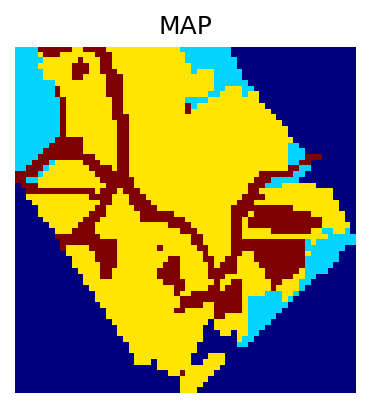

In [4]:
map=MapLoader().load("gangjin.crop1")
vis.showJetMap(map)

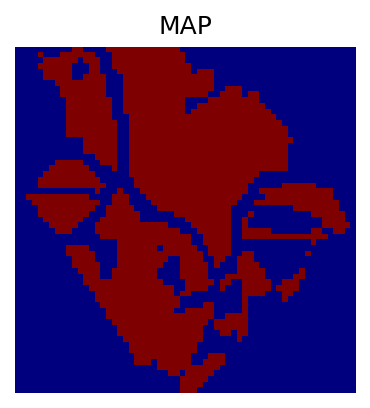

In [5]:
installable_layer = layer_map(map, keep_values=[2])
vis.showJetMap(installable_layer)

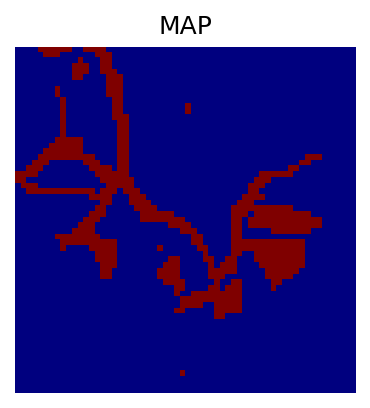

In [6]:
road_layer = layer_map(map, keep_values=[3])
vis.showJetMap(road_layer)

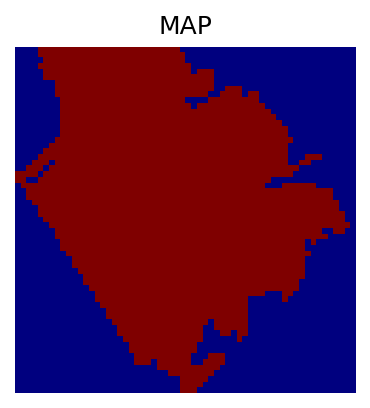

In [7]:
jobsite_layer = layer_map(map, keep_values=[2,3])
vis.showJetMap(jobsite_layer)

센서가 설치가능한 구역 중에서 최외곽센서 설치 가능 지점 탐색

In [8]:
corner_layer = HarrisCorner(map)

In [9]:
corner_candidate = corner_layer.run(installable_layer, blockSize=3, ksize=3, k=0.1, dilate_size=7)
print(corner_candidate)
print(len(corner_candidate), type(corner_candidate))

[(30, 2), (5, 3), (35, 6), (17, 8), (11, 19), (18, 20), (46, 20), (5, 22), (45, 26), (13, 30), (26, 30), (54, 32), (11, 36), (16, 37), (36, 38), (27, 39), (41, 43), (30, 44), (38, 48)]
19 <class 'list'>


설치 가능한 지점 위에서만 후보 추출하는 과정(코너 후보 지점들이 정확한 코너지점들 추출이 안되서..)

In [10]:
import numpy as np

installable = np.asarray(installable_layer).astype(bool)  # True = installable
H, W = installable.shape

corner_candidate = [
    (x, y) for (x, y) in corner_candidate
    if 0 <= x < W and 0 <= y < H and installable[y, x]
]


Outmost corner points: 7


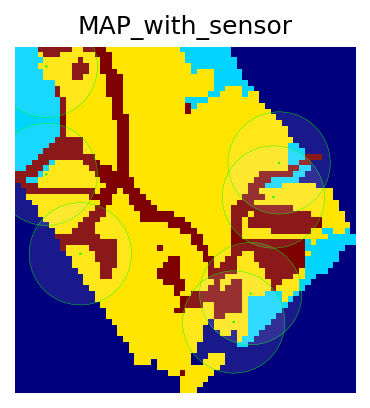

In [ ]:
##중요 corner_candidate 는 나중에 사용할 것임

print("Outmost corner points:", len(corner_candidate))
vis.showJetMap_circle(map, corner_candidate, radius=45)

최외곽 지점에 설치된 센서가 현장의 설치가능한 맵(installable)에서 얼마나 커버하는 파악하는 과정

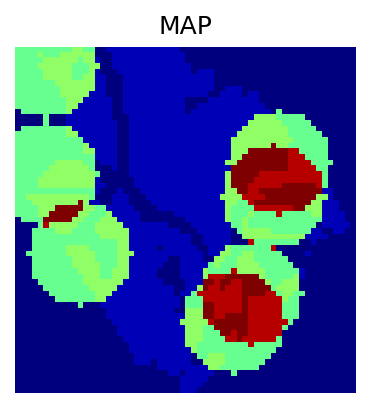

In [12]:
sensor = Sensor(installable_layer)
cov_layer = sensor.deploy(corner_candidate)
vis.showJetMap(cov_layer)

최외곽 설치된 센서가 커버하는 영역

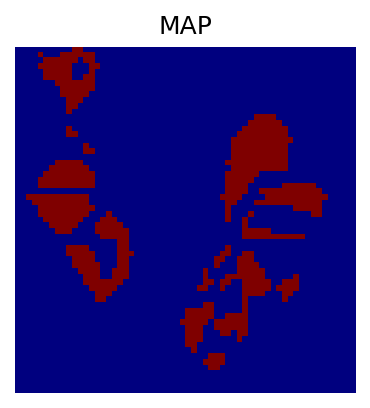

In [13]:
vis.showJetMap(sensor.covered())    # numpy uint8(0/255)

최외곽 센서가 커버하지 못하는 영역

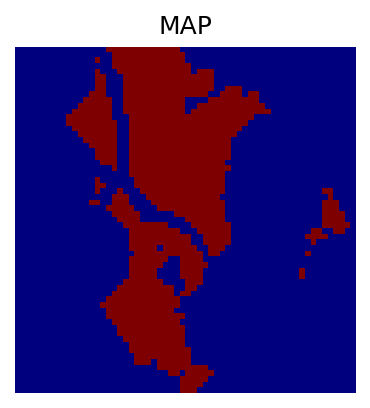

In [14]:
vis.showJetMap(sensor.uncovered())  # numpy uint8(0/255)

In [16]:
pt = sensor.uncovered(points=True) #여기서 커버되지 않은 그리드의 좌표점 추출이 필요
print(len(pt), pt)

994 [(16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (14, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (17, 3), (18, 3), (19, 3), (20, 3), (21, 3), (22, 3), (23, 3), (24, 3), (25, 3), (26, 3), (27, 3), (28, 3), (29, 3), (30, 3), (14, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (32, 4), (33, 4), (34, 4), (14, 5), (15, 5), (19, 5), (20, 5), (21, 5), (22, 5), (23, 5), (24, 5), (25, 5), (26, 5), (27, 5), (28, 5), (29, 5), (30, 5), (31, 5), (32, 5), (33, 5), (34, 5), (14, 6), (15, 6), (19, 6), (20, 6), (21, 6), (22, 6), (23, 6), (24, 6), (25, 6), (26, 6), (27, 6), (28, 6), (29, 6), (30, 6), (31, 6), (32, 6), (33, 6), (34, 6), (14, 7), (15, 7), (19, 7), (20, 